In [1]:
from NEOreadIn import *

In [16]:
from NEOimportTQTPPIspectro import *
from commonImports import *
from sigFit import *

In [17]:
basePath = '/Users/duomii/Desktop/PhD/Data'

In [18]:
studyPath = basePath + '/DZ_4DoubleTestMedSup_1_46_20240114_143553/'
startFolder, stopFolder, IsFixed = 41, 138, 1

In [19]:
skipIndices = [114,115,116]
skipIndices = np.unique(skipIndices)
skipIndices = skipIndices[skipIndices > startFolder]
skipIndices = skipIndices[skipIndices < stopFolder]

mqFIDall, mqSpectraAll, tau, complexDataAllPhaseAll = [], [], [], []
j = 0 # index for multiple repetitions
evoTimes = np.zeros((stopFolder - startFolder - len(skipIndices)+1, 1))
if IsFixed:
    fixedFIDall, complexDataFixedAll = [], []

for k in np.arange(startFolder,stopFolder+1):
    if k in skipIndices:
        continue
    dataPath = studyPath + f'{k}/'
    print(f'Folder: {k}')

    preFilter = 0 # Cos²-Fkt um Rauschen im FID entlang omega abzuschneiden (1)
    filterFacPre = 1 # 1 ist genau die Länge von FID. 2 -> halbe Länge

    filter2ndDim = 0 # Cos²-Fkt entlang der EvoTime-Richtung vor der FFT (1). Max Gewichtung bei kleinen EvoTime
    filterFac2ndDim = 1 # 1 ist genau die Länge von EvoTime. 2 -> halbe Länge

    filterFID = 0 # Cos²-Fkt um Rauschen im mqFID entlang EvoTime abzuschneiden nach der FFT (2)
    filterFacPost = 1 #

    preDCcomp = 1 #
    spikeComp = 1 # mega Spike ist weil 5 µs (?) Delay zwischen RF und ADC nicht eingebaut
    postDCcomp = 1
    phaseCorr = 1 # Phasenkorrektur, ausschalten für IRTQTPPI fixed
    w0corr = 1
    zeroFill = 1

    onlyReal = 1; # FFT of real components or of real and imag. 1 = sym, 0 = asym

    freqDriftVal = [0, 0, 0]

    """(method, rawComplexData, complexDataAllPhase, complexDataUnw, realDataAllPhase,
    realDataAllPhaseUnw, mqFID, mqSpectra, mixTime, evoTime) = importTQTPPIspec(dataPath, spikeComp, phaseCorr, preDCcomp, filter2ndDim, filterFac2ndDim,
                     preFilter, filterFacPre, w0corr, freqDriftVal, postDCcomp, filterFID, filterFacPost, onlyReal)
    """
    (method, rawComplexData, complexDataAllPhase, complexDataUnw, realDataAllPhase,
     realDataAllPhaseUnw, mqFID, mqSpectra, mixTime, evoTime) = importTQTPPIspec(dataPath, spikeComp, phaseCorr,
                                                                                 preDCcomp, filter2ndDim,
                                                                                 filterFac2ndDim,
                                                                                 preFilter, filterFacPre, w0corr,
                                                                                 freqDriftVal, postDCcomp, filterFID,
                                                                                 filterFacPost, onlyReal)



    try:
        MediumInversionTimes.append(method['InversionTimeMedium'])


    except:
        print('No Medium InvTime found!!')
        pass

    NR = method['Repetitions']
    print(f'Mixing Time: {method["MixTime"]} \n EvoTime: {method["EvoTime"]}')
    #print(method['MedInvTime'])
    if method['Method'] == '<User:sr_DQF>' or method['Method'] == '<User:sr_TQF1>':
        pass
    else:

        sqVal = np.max(np.abs(mqSpectra[int(np.fix(mqSpectra.shape[0]/4)):int(np.fix(mqSpectra.shape[0]/2)),0]), axis=0)
        posSq = np.argmax(np.abs(mqSpectra[int(np.fix(mqSpectra.shape[0]/4)):int(np.fix(mqSpectra.shape[0]/2)),0]), axis=0)
        # Korrektur nötig, weil zuvor in 8:16 gesucht, d.h. posSq bezieht sich
        # auf diese paar Schichten
        posSq += int(np.fix(np.size(mqSpectra,0)/4)) - 1
    #     tqVal, posTq = np.max(np.abs(mqSpectra[int(np.fix(posSq/3))-2:int(np.fix(posSq/3))+2,0,0])), axis=0
    #     posTq = np.fix(posSq/3) - 2 + posTq - 1
        posTq = int(np.ceil(posSq/3))
    if method['Method'] == '<User:dk_Tqtppi_fix1>' or IsFixed or method['Method']== '<User:sr_DQF>':
        evoTimeVec = np.arange(1, np.size(mqFID,0)+1)
    else:
        evoTimeVec = np.arange(evoTime, method['EvoTimeStep']*0.001*(method['NumPhaseSteps']*method['NumPhaseCycles']-1)/(np.size(mqFID,0)-1)+evoTime, method['EvoTimeStep']*0.001*(method['NumPhaseSteps']*method['NumPhaseCycles']-1)/(np.size(mqFID,0)-1))


    if NR == 1:

        if IsFixed:
            fixedFIDall.append(mqFID)

            mqSpectraAll.append(mqSpectra)
            tau.append(evoTime)
            evoTimes[j] = method['EvoTime']
            j += 1
        elif method['Method'] == '<User:sr_DQF>':
            mqFIDall.append(mqFID)
            mqSpectraAll.append(mqSpectra)
            complexDataAllPhaseAll.append(complexDataAllPhase)
            tau.append(evoTime)
            evoTimes[j] = method['EvoTime']
            j += 1
        else:
            mqFIDall.append(mqFID)
            mqSpectraAll.append(mqSpectra)
            tau.append(evoTime)
            evoTimes[j] = method["EvoTime"]
            j += 1
    else:
        if IsFixed: #and method.Method == '<User:sr_IRTQTPPI_0180supr>':
            mqFID_tmp = np.mean(mqFID, axis=1)
            complexData_temp = np.mean(complexDataAllPhase, axis=0) # needed for new reconstruction
            mqSpectra_tmp = np.mean(mqSpectra, axis=1)
    #         mqFID1[:,j:j+NR-1] = mqFID
            fixedFIDall.append(mqFID_tmp)
            complexDataFixedAll.append(complexData_temp)
            mqSpectraAll.append(mqSpectra_tmp)
            tau.append(evoTime)
            evoTimes[j] = method['EvoTime']
            j += 1
        elif method['Method'] == '<User:sr_DQF>':
            complexDataAllPhaseAll.append(complexDataAllPhase)
            tau.append(evoTime)
            evoTi = int(j / NR)
            evoTimes[evoTi] = method['EvoTime']
            j = j + NR

        else:
            mqFID_temp = np.mean(mqFID, axis=1)
            mqFIDall.append(mqFID_temp)
            mqSpectra_tmp = np.mean(mqSpectra, axis=1)
            mqSpectraAll.append(mqSpectra_tmp)
            tau.append(evoTime)
            evoTi = int(j / NR)
            evoTimes[evoTi] = method['EvoTime']
            j = j + NR
            print(j)


Folder: 41
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -370789335.498995
         Iterations: 32
         Function evaluations: 64
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 0.43842
Folder: 42
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -370623990.394541
         Iterations: 31
         Function evaluations: 62
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 0.6
Folder: 43
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -368850238.408971
         Iterations: 32
         Function evaluations: 64
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 0.8
Folder: 44
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -366625965.150977
         Iterations: 31
         Function evaluations: 62
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTi

No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 6.8
Folder: 74
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -308619127.835057
         Iterations: 31
         Function evaluations: 62
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 7
Folder: 75
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -305706887.073520
         Iterations: 31
         Function evaluations: 62
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 7.2
Folder: 76
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -302205688.596557
         Iterations: 32
         Function evaluations: 64
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 7.4
Folder: 77
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -303832324.443459
         Iterations: 31
         Function evaluations: 6

No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 13.4
Folder: 107
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -262222786.877638
         Iterations: 30
         Function evaluations: 60
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 13.6
Folder: 108
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -262740067.257092
         Iterations: 31
         Function evaluations: 62
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 13.8
Folder: 109
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -262599682.196643
         Iterations: 31
         Function evaluations: 62
No Medium InvTime found!!
Mixing Time: 152.42 
 EvoTime: 14
Folder: 110
EXECEption at *
EXECEption at *
Optimization terminated successfully.
         Current function value: -258732943.140305
         Iterations: 31
         Function evalua

In [20]:
mqSpecAll = np.array(mqSpectraAll)

In [21]:
mqFIDs = np.array(fixedFIDall.copy())
complexFixedFIDs = np.array(complexDataFixedAll.copy())
fit1 = fixedFitTQTPPI(mqFIDs, evoTimes, method['NumPhaseCycles'])
pfitSQ, pfitTQ = fit1.fitTQsecondDim()
#fit2 = fixedFitTQTPPI(complexFixedFIDs, evoTimes)
print(str(fit1.posSq) + str(fit1.posTq) )
TQs, SQs = fit1.TQs, fit1.SQs

4816


In [25]:
pSQ,_ = pfitSQ
pTQ, _ = pfitTQ

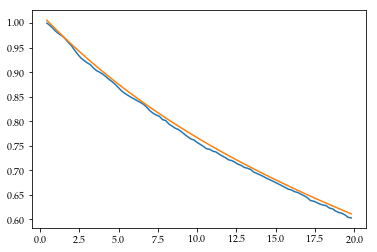

In [27]:
plt.plot(evoTimes,real(mqSpecAll[:,48])/np.max(real(mqSpecAll[:,48])))
plt.plot(evoTimes, fit1.f_11(evoTimes, *pSQ))

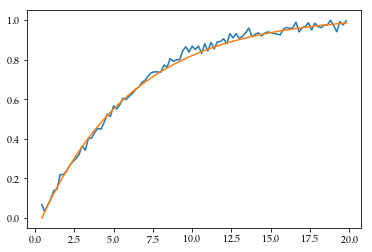

In [28]:
plt.plot(evoTimes,real(mqSpecAll[:,16])/np.max(real(mqSpecAll[:,16])))
plt.plot(evoTimes, fit1.f_31(evoTimes, *pTQ))